In [ ]:
'''
정확도는 실제 데이터에서 예측 데이터가 얼마나 같은지를 판단하는 지표입니다. 
Accuracy = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수 입니다.
여기서 중요한 것은 정확도는 불균형한 레이블 값 분포에서 모델의 성능을 판단할 경우, 적절한 평가 지표가 아닙니다.
예를들면 코드로 확인하겠지만, 타이타닉 데이터에서 전체 생존률과, 단순히 데이터의 성별이 여성일 경우를 비교해보면
그 값이 비슷하게 나옵니다. 이처럼 데이터 분포도가 균일하지 않은 경우, 높은 수치가 나타날 수 있는 것이 정확도 평가 지표의 맹점입니다.
이를 코드로 직접 확인해 보도록 하겠습니다.
'''

In [1]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

##null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace = True)
    df['Cabin'].fillna('N', inplace = True)
    df['Embarked'].fillna('N', inplace = True)
    df['Fare'].fillna(0, inplace = True)
    return df

##불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis = 1, inplace = True)
    return df

##레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

#전처리 함수들 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [2]:
from sklearn.base import BaseEstimator
##BaseEstimator를 상속받으면 Customized형태의 Estimator를 만들 수 있습니다.

class MyDummyClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i]=0
            else:
                pred[i] = 1
        return pred

In [3]:
titanic_df = pd.read_csv("./titanic_train.csv")
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis = 1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size = 0.2, random_state = 0)

myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)
pred = myclf.predict(X_test)
print(accuracy_score(pred, y_test))
##아래 결과를 보시면 데이터를 통해서 분석한 생존률과, 단순히 성별이 여성일때를 생존이라고 취급하고 생존률을 구했을때와
##값이 비슷한 것을 알 수 있습니다. 따라서 이러한 결과가 나오지 않기 위해 정확도 척도를 사용할 때에는 주의가 필요합니다.
##이러한 단점을 보완하기 위해 우선 오차 행렬에 대해 살펴보도록 하겠습니다.

0.7877094972067039


In [ ]:
'''
오차행렬은 학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈려하는지를 함께 보여주는 지표입니다.
즉, 이진 분류의 예츠 오류가 얼마인지와 더불어 어떠한 유형의 예측 오류가 발생하고 있는지를 함께 나타내는 지표입니다.
오차행렬의 형식은 다음과 같습니다.
            N(0)   P(1)
     N(0)   TN     FP
     P(1)   FN     TP
TN은 예측을 N으로 예측했는데 실제 값도 N이라는 뜻입니다. 여기서 정확도는 전체 경우에서 예측이 맞은 경우이므로,
accuracy = (TN + TP)/(TN + TP + FP + FN) 입니다.
사이킷런에서 오차 행렬을 구하기 위해 confusion_matirx()라는 함수를 제공합니다.
'''

In [4]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

array([[92, 18],
       [20, 49]], dtype=int64)

In [ ]:
'''
정밀도는 예측을 Positive로 한 대상 중 예측과 실제 값이 Positive로 일치한 데이터의 비율입니다.
재현율은 실제 값이 positive인 대상 중에서 예측과 실제 값이 Positive로 일치한 데이터의 비율입니다.
정밀도 = TP/(TP + FP)
재현율 = TP/(FN + TP)

실제 Positive 양성인 데이터 예측을 Negative로 잘못 판단하게되면 업무상 큰 영향이 발생하는 경우 재현율이 더 중요한 지표입니다.
실제 Negative 음성인 데이터 예측을 Positive로 잘못 판단하게되면 업무상 큰 영향이 발생하는 경우 정밀도이 더 중요한 지표입니다.

타이타닉 데이터를 오차 행렬 및 정밀도, 재현율을 모두 고려하여 예측 성능을 평가해 보겠습니다.
'''

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

##오차행렬, 정확도, 정밀도, 재현율 등을 한번에 호출하는 함수
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print("오차행렬")
    print(confusion)
    print("정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}".format(accuracy, precision, recall))

In [6]:
import warnings
warnings.filterwarnings(action='ignore')

titainc_df = pd.read_csv("./titanic_train.csv")
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop("Survived", axis = 1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test= train_test_split(X_titanic_df, y_titanic_df, test_size = 0.2, random_state = 11)

lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


In [7]:
##정밀도와 재현율을 높일 수 있는 방법에 대해 알아보겠습니다.
##정밀도와 재현율은 상호 보완적인 평가 지표입니다. 따라서 한쪽을 강제로 높이면 다른 한쪽의 수치는 떨어집니다.
##이를 정밀도/재현율 트레이드오프라고 합니다.
#이를 이해하기 전에 predict매소드를 자세히 살펴보도록하겠습니다.

##predict는 우선 예측 데이터가 어느 레이블에 속하는지 알기 위해 개별 레이블별로 결정확률을 구합니다.
##그 후 임계값 이상의 확률을 갖는 레이블로 최족 예측하게 되는 것입니다.

pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print(pred_proba.shape)
print(pred_proba[:3])

print('\n')

pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis = 1)
print(pred_proba_result[:3])

print('\n')

print(pred[:3])

##predict는 predict_proba메서드에 기반해서 생성된 API입니다. predict는 predict_proba의 두번쨰 칼럼의 결과를 이용한 것입니다.
##이를 이해하는 것이 사이킷런이 어떻게 트레이드오프를 구현했는지를 이해하는데 도움을 줍니다.
##임계값을 조정함으로써 정밀도와 재현율의 성능 수치를 상호 보완적으로 조정할 수 있습니다. 
##이러한 로직을 직접 구현해 보면서 재현율/정밀도 트레이드오프를 이해해 보겠습니다.

(179, 2)
[[0.4616653  0.5383347 ]
 [0.87862763 0.12137237]
 [0.87727002 0.12272998]]


[[0.4616653  0.5383347  1.        ]
 [0.87862763 0.12137237 0.        ]
 [0.87727002 0.12272998 0.        ]]


[1 0 0]


In [8]:
##이를 위해 Binarizer클래스 사용법을 알아보겠습니다.
##이 클래스는 넘파이 어레이를 treshold를 기준으로 이하는0, 초과는 1로 바꿔줍니다.

from sklearn.preprocessing import Binarizer

X = [[1,-1,2],[2,0,0],[0,1.1,1.2]]
binarizer = Binarizer(threshold=1.1)
binarizer.fit_transform(X)

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [9]:
##이 클래스를 이용하여 predict의 의사 코드를 작성해보겠습니다.
custom_threshold = 0.5

pred_proba_1 = pred_proba[:, 1].reshape(-1,1)

binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)
##결과를 보시면 위에서 작성한 predict를 이용한 결과와 똑같은 것을 알 수 있습니다.

오차행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


In [10]:
##임계값을 0.4로 해보겠습니다.

custom_threshold = 0.4

pred_proba_1 = pred_proba[:, 1].reshape(-1,1)

binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.7286, 재현율: 0.8361


In [11]:
##재현율을 증가했지만 정확도와 정밀도는 떨어진 것을 확인할 수 있습니다.
##이는 참이라고 판별하는 기준을 완화하면서, Positive로 예측할 확률이 올라가게됩니다.
##따라서 재현율은 올라가지만 그에 따라 나머지 값들은 작아지게 됩니다.

In [16]:
##임계값을 0.4~0.6까지 0.05씩 증가하면서 각 결과를 관찰해보겠습니다.

thresholds = [0.4,0.45,0.5,0.55,0.6]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for customed_threshold in  thresholds:
        binarizer = Binarizer(threshold = customed_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임계 값: ', customed_threshold)
        get_clf_eval(y_test, custom_predict)
        print('\n')
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임계 값:  0.4


AttributeError: 'Series' object has no attribute 'pred'

In [13]:
##이러한 과정을 간단하게 해주는 함수가 precision_recall_curve함수입니다.
##입력으로 실제 클래스값 배열, 예측확률배열을 받고 출력으로 정밀도와 재현율, 임계값을 반환합니다.

from sklearn.metrics import precision_recall_curve

pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)

##이때 thresholds는 임계값들의 배열이므로, 특정 인덱스만을 뽑아서 따로 사용합니다.
thr_index = np.arange(0, thresholds.shape[0], 15)
print("index: ", thr_index)
print("임계값: ", np.round(thresholds[thr_index], 2))
print('\n')
print("정밀도: ", np.round(precisions[thr_index],2))
print("재현율: ", np.round(recalls[thr_index], 2))

index:  [  0  15  30  45  60  75  90 105 120 135]
임계값:  [0.1  0.12 0.14 0.19 0.28 0.4  0.57 0.67 0.82 0.95]


정밀도:  [0.39 0.44 0.47 0.54 0.65 0.73 0.84 0.95 0.96 1.  ]
재현율:  [1.   0.97 0.9  0.9  0.9  0.84 0.75 0.61 0.38 0.15]


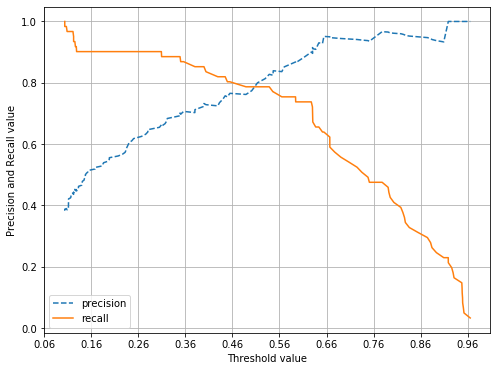

In [14]:
##위 결과를 그래프로 나타내면 다음과 같습니다.
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8,6))
    threshold_boundry = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundry], linestyle = "--", label = "precision")
    plt.plot(thresholds, recalls[0:threshold_boundry], label = "recall")
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel("Threshold value")
    plt.ylabel("Precision and Recall value")
    plt.legend()
    plt.grid()
    plt.show()
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

##그래프에서 보이는 것처럼, 임계값이 변할수록 정밀도와 재현율이 변화합니다.
##상대적인 중요도를 부요해 알고리즘을 튜닝할 수 있지만, 단순히 하나의 성능 지표를 높이기 위한 수단으로 임계값을 변경하는 행위는
##주의해야합니다.

In [18]:
##F1 스코어는 정밀도와 재현율을 결합한 지표입니다. 정밀도와 재현율이 어느 한쪽으로 치우치지 않을경우 높은 값을 가집니다.
##수식은 다음과 같습니다.
##2*(precision x recall) / (precision + recall)
##사이킷런에서는 f1_score라는 API를 제공합니다.

from sklearn.metrics import f1_score

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)                 ##f1 score 추가
    print("오차행렬")
    print(confusion)
    print("정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}".format(accuracy, precision, recall, f1))
    
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1,1), thresholds)

임계 값:  0.4
오차행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.7286, 재현율: 0.8361, F1: 0.7786


임계 값:  0.45
오차행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1: 0.7840


임계 값:  0.5
오차행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1: 0.7805


임계 값:  0.55
오차행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1: 0.7931


임계 값:  0.6
오차행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1: 0.8036




In [ ]:
'''
ROC 곡선과 이에 기반한 AUC 스코어는 이진 분류의 예측 성능 측정에서 중요하게 사용되는 지표입니다.
ROC 곡선은 FPR이 변할 때 TPR이 어떻게 변하는지를 나타내는 곡선입니다.
TPR은 재현율입니다. 따라서 TPR = TP/(FN + TP) 입니다.
재현율에 대응되는 지표로 TNR이 있습니다.
TNR = TN/(TN + FP)입니다.
FPR = FP/(TN + FP)이므로
FPR = 1-TNR이라는 관계가 성립합니다.

ROC곡선이 적선에서 멀어질수록 성능이 뛰어난 것으로 판단합니다.
이때 ROC그래프를 그리기 위해 FPR을 0~1로 변화시키기 위해 임계값을 변경해야합니다.
임계값이 1이면 FP가 0이기 떄문에 FPR이 0이됩니다. 임계값을 줄이면 FPR 값이 증가하게됩니다.

사이킷런은 ROC곡선을 구하기 위해 roc_curve() API를 제공합니다.
'''

In [20]:
from sklearn.metrics import roc_curve

pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
thr_index = np.arange(1, thresholds.shape[0], 5)
print(thr_index)
print(np.round(thresholds[thr_index], 2))
print(np.round(fprs[thr_index],2))
print(np.round(tprs[thr_index],2))

[ 1  6 11 16 21 26 31 36 41 46 51]
[0.97 0.65 0.63 0.57 0.45 0.38 0.31 0.13 0.12 0.11 0.1 ]
[0.   0.02 0.03 0.08 0.13 0.19 0.24 0.58 0.62 0.75 0.81]
[0.03 0.64 0.7  0.75 0.8  0.85 0.9  0.9  0.95 0.97 1.  ]


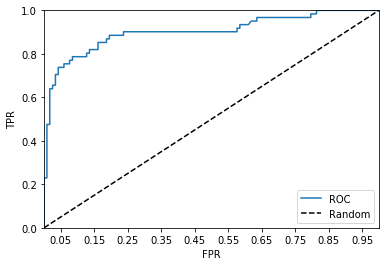

In [21]:
##이를 ROC곡선으로 시각화하면 다음과 같습니다.
def roc_curve_plot(y_test, pred_proba_c1):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    plt.plot(fprs, tprs, label = 'ROC')
    plt.plot([0,1], [0,1], 'k--',label = 'Random')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
roc_curve_plot(y_test, pred_proba[:,1])

In [ ]:
'''
ROC곡선이 직선과 멀리 떨어져 있어야 좋은 성능을 보입니다. 일반적으로 ROC 곡선 자체는 FPR과 TPR의 변화 값을 보는데 이용하며,
분류의 성능 지표로 사용되는 것은 ROC 곡선 면적에 기반한 AUC값입니다. 면적의 넓이가 1에 가까울수록 좋은 수치입니다.
넓이를 크게 하기 위해서는 FPR이 작은 상태에서 얼마나 큰 TPR을 얻을수 있느냐가 중요합니다.
'''